In [48]:
import numpy as np
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt

from markowitz_utils import *

%load_ext autoreload 
%autoreload 2

In [49]:
returns = pd.read_csv("data/49_industries.csv", index_col=0).loc["2015-01-01":]
returns.index = pd.to_datetime(returns.index)

In [1]:
import refinitiv.data.eikon as ek
import datetime

ek.set_app_key('e3cead6cf0e843259e8d9cbfe076deb53d8fb2c7')

In [33]:
# download FOREX from Eikon

data = ek.get_timeseries(["EUR=", "GBP=", "JPY=", "AUD=", "CAD=", "CHF="],
                    start_date="2000-01-01",
                    end_date="2023-12-31",
                    interval="hour",
                    count=10000,)


In [46]:
data[[("EUR=", "CLOSE"), ("GBP=", "CLOSE"), ("JPY=", "CLOSE")]].isna().sum().sum() / data[[("EUR=", "CLOSE"), ("GBP=", "CLOSE"), ("JPY=", "CLOSE")]].size

0.015982787767020133

In [357]:
np.random.seed(1)

covs_temp = returns.ewm(halflife=250, min_periods=500).cov().dropna()

covariances = {}
for time in covs_temp.index.levels[0][500:]:
    covariances[time] = covs_temp.loc[time]

# mus are returns plus noise
variance_eps = np.random.uniform(0, 100, size=(len(returns.columns),)) ** 2
# variance_eps = np.ones_like(variance_eps) * 0.14
variance_r = returns.var().values
alphas = variance_r /  (variance_r+ variance_eps)
Sigma_mu = np.diag(variance_eps)

noise = np.random.multivariate_normal(np.zeros(len(returns.columns)), Sigma_mu, size=len(returns))

# mus = returns.ewm(halflife=63, min_periods=500).mean().shift(1).dropna()
mus = (returns + noise) * alphas.reshape(1,-1)

# shifte covariance keys by 1
indices = list(covariances.keys())
covariances = {indices[i+1]: covariances[indices[i]] for i in range(len(indices)-1)}

# Simulated data

In [246]:
np.random.seed(1)
correlation_true = np.array([[1,0.99], [0.99,1]])
std_true = np.diag(np.array([0.05, 0.05]))

covariance_true = (std_true @ correlation_true @ std_true) / 250
mus_true = np.array([0.05 / 250, 0.04 / 250])
returns_sim = np.random.multivariate_normal(mus_true, covariance_true, size=1000)

returns_sim = pd.DataFrame(returns_sim, columns=["A", "B"])
returns_sim.index = returns.index[-1000:]

In [247]:
np.random.seed(1)

covs_temp = returns_sim.ewm(halflife=21, min_periods=21).cov().dropna()

covariances = {}
for time in covs_temp.index.levels[0][21:]:
    covariances[time] = covs_temp.loc[time]

indices = list(covariances.keys())
covariances = {indices[i+1]: covariances[indices[i]] for i in range(len(indices)-1)}

mus = returns_sim.ewm(halflife=63, min_periods=21).mean().shift(1).dropna()

# Benchmark backtest

In [249]:
# paramters
sigma_tar = 0.05
lower=None
upper = None
leverage = None

In [250]:
porfolio_weights_bm, metrics_bm = backtest_markowitz(returns_sim, mus, covariances, sigma_tar, lower, upper, leverage, lower_cash=None, upper_cash=None, transaction_cost=0, metrics_transaction_cost=1)

print("SR: ", metrics_bm.sharpe_ratio)
print("turnover: ", metrics_bm.turnover)
print("risk: ", metrics_bm.std_return)
print("drawdown: ", metrics_bm.drawdown.max())

100%|██████████| 978/978 [00:01<00:00, 649.97it/s]


SR:  -1.6298766254633075
turnover:  93.4831840638831
risk:  0.052082904125456665
drawdown:  0.3165588978424346


<Axes: >

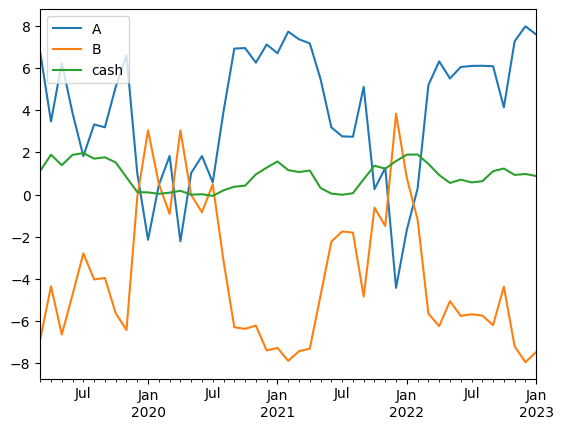

In [253]:
porfolio_weights_bm.resample("M").mean().plot()

# Robust mean

In [260]:
# paramters
sigma_tar = 0.05
lower=None
upper = None
leverage = None

alpha_uncertainties = mus.abs()*1


# alpha_uncertainties = mus.ewm(halflife=63).std() * 0.0001

In [261]:
porfolio_weights_robust, metrics_robust = backtest_markowitz(returns_sim, mus, covariances, sigma_tar, lower, upper, leverage, lower_cash=None, upper_cash=None, transaction_cost=0, metrics_transaction_cost=1, alpha_uncertainties=alpha_uncertainties)

print("SR: ", metrics_robust.sharpe_ratio)
print("turnover: ", metrics_robust.turnover)
print("risk: ", metrics_robust.std_return)
print("drawdown: ", metrics_robust.drawdown.max())

100%|██████████| 978/978 [00:01<00:00, 667.73it/s]


SR:  -0.599154412402139
turnover:  57.12635777708588
risk:  0.013370719219209893
drawdown:  0.04382513039497046


<Axes: >

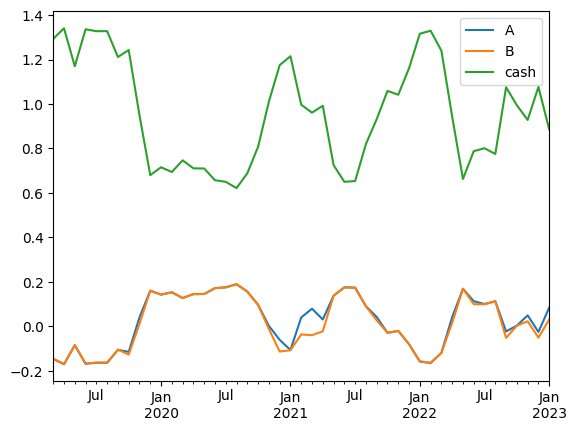

In [262]:
porfolio_weights_robust.resample("M").mean().plot()

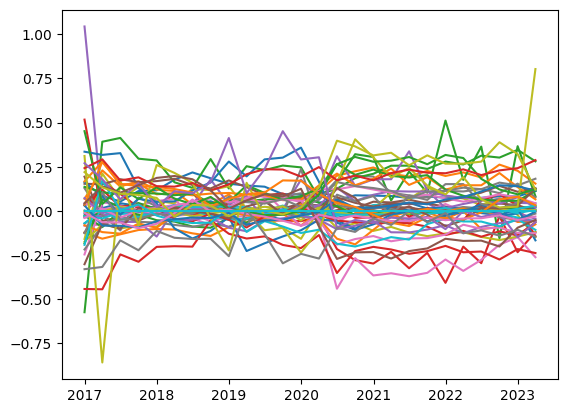

In [347]:
# stackplot
quarterly = porfolio_weights_robust.resample("Q").mean()
plt.plot(quarterly)
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.stackplot(quarterly.index, quarterly.T, labels=quarterly.columns)
# plt.legend()
plt.show()

<Axes: >

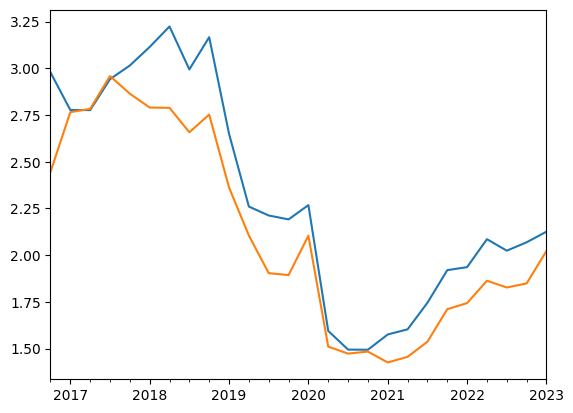

In [340]:
porfolio_weights_robust.abs().max(axis=1).resample("Q").mean().plot()

porfolio_weights_bm.abs().max(axis=1).resample("Q").mean().plot()

<Axes: >

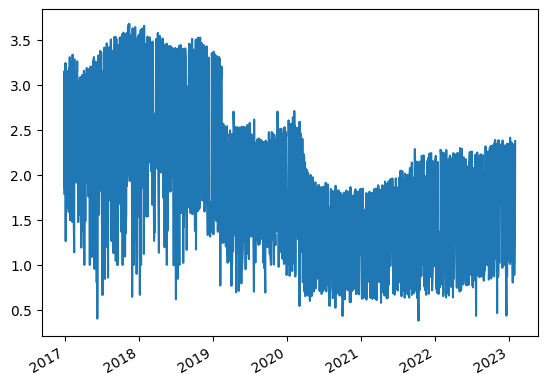

In [331]:
porfolio_weights_robust.max(axis=1).plot()


# Get low rank covariance approximation